In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [5]:

# Importar base de treino
pjme=pd.read_csv("Base_historico_Geral v2.csv", index_col=[0], parse_dates=[0], delimiter = ',')

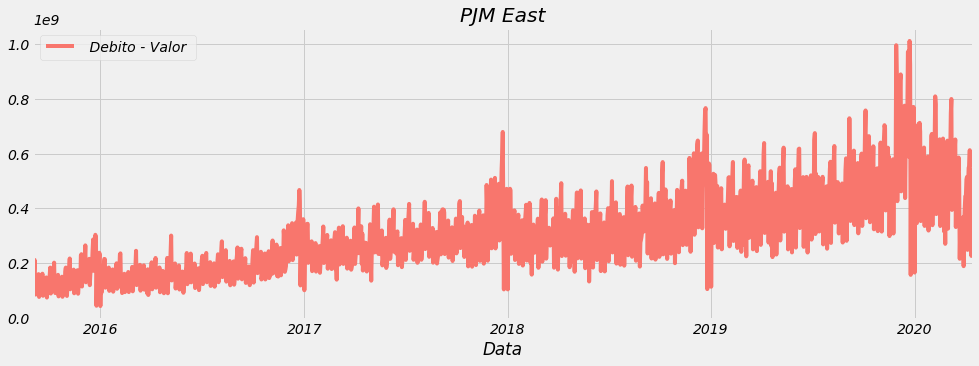

In [6]:
pd.plotting.register_matplotlib_converters()
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.loc[:,[' Debito - Valor ']].plot(figsize=(15,5), color=color_pal[0], title='PJM East')

In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    #       'dayofyear','dayofmonth','weekofyear','5_dia_util','feriado','vespera_feriado','pos_feriado']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label=' Debito - Valor ')

features_and_target = pd.concat([X, y], axis=1)

In [8]:
features_and_target.tail()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Debito - Valor
Data,,,,,,,,
2020-04-10,4,2,4,2020,101,10,15,2.793107e+08
2020-04-11,5,2,4,2020,102,11,15,5.401601e+08
2020-04-12,6,2,4,2020,103,12,15,2.265079e+08
2020-04-13,0,2,4,2020,104,13,16,4.291742e+08
2020-04-14,1,2,4,2020,105,14,16,4.143175e+08


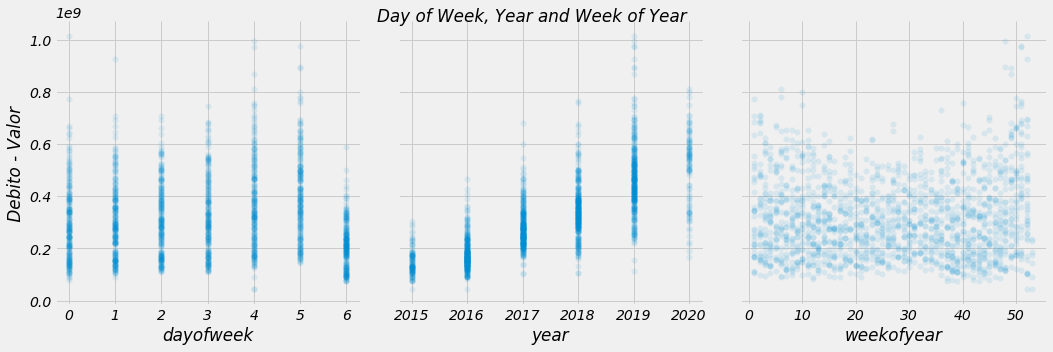

In [9]:
sns.pairplot(features_and_target.dropna(),
             x_vars=['dayofweek','year','weekofyear'],
             y_vars=' Debito - Valor ',
             height=5,
             plot_kws={'alpha':0.1, 'linewidth':0}
            )
plt.suptitle('Day of Week, Year and Week of Year')
plt.show()

In [10]:
split_date = '29-02-2020'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [11]:
# Format data for prophet model using ds and y
pjme_train.reset_index().rename(columns={'Data':'ds', ' Debito - Valor ':'y'}).head()

,ds,y
0,2015-09-02,1.258808e+08
1,2015-09-03,1.275257e+08
2,2015-09-04,1.713704e+08
3,2015-09-05,2.119238e+08
4,2015-09-06,9.713388e+07


In [12]:
ano_novo = pd.DataFrame({
  'holiday': 'Ano Novo',
  'ds': pd.to_datetime(['2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01']),
  'lower_window': 0,
  'upper_window': 1,
})
carnaval = pd.DataFrame({
  'holiday': 'Carnaval',
  'ds': pd.to_datetime(['2015-02-16','2015-02-17','2016-02-08','2016-02-09','2017-02-27','2017-02-28','2018-02-12','2018-02-13','2019-03-04','2019-03-05','2020-02-24','2020-02-25']),
  'lower_window': 0,
  'upper_window': 1,
})
corpus_christi = pd.DataFrame({
  'holiday': 'Corpus Christi',
  'ds': pd.to_datetime(['2015-06-04','2016-05-26','2017-06-15','2018-05-31','2019-06-20','2020-06-11']),
  'lower_window': 0,
  'upper_window': 1,
})
dia_trabalho = pd.DataFrame({
  'holiday': 'Dia do Trabalho',
  'ds': pd.to_datetime(['2015-05-01','2016-05-01','2017-05-01','2018-05-01','2019-05-01','2020-05-01']),
  'lower_window': 0,
  'upper_window': 1,
})

finados = pd.DataFrame({
  'holiday': 'Finados',
  'ds': pd.to_datetime(['2015-11-02','2016-11-02','2017-11-02','2018-11-02','2019-11-02','2020-11-02']),
  'lower_window': 0,
  'upper_window': 1,
})


independencia = pd.DataFrame({
  'holiday': 'Independencia',
  'ds': pd.to_datetime(['2015-09-07','2016-09-07','2017-09-07','2018-09-07','2019-09-07','2020-09-07']),
  'lower_window': 0,
  'upper_window': 1,
})


natal = pd.DataFrame({
  'holiday': 'natal',
  'ds': pd.to_datetime(['2015-12-25','2016-12-25','2017-12-25','2018-12-25','2019-12-25','2020-12-25']),
  'lower_window': 0,
  'upper_window': 1,
})

padroeira = pd.DataFrame({
  'holiday': 'Nossa Sr.a Aparecida',
  'ds': pd.to_datetime(['2015-10-12','2016-10-12','2017-10-12','2018-10-12','2019-10-12','2020-10-12']),
  'lower_window': 0,
  'upper_window': 1,
})

pascoa = pd.DataFrame({
  'holiday': 'Pascoa',
  'ds': pd.to_datetime(['2015-04-03','2016-03-25','2017-04-14','2018-03-30','2019-04-19','2020-04-10']),
  'lower_window': 0,
  'upper_window': 1,
})

proclamacao = pd.DataFrame({
  'holiday': 'Proclamacao da republica',
  'ds': pd.to_datetime(['2015-11-15','2016-11-15','2017-11-15','2018-11-15','2019-11-15','2020-11-15']),
  'lower_window': 0,
  'upper_window': 1,
})

tiradentes = pd.DataFrame({
  'holiday': 'Tiradentes',
  'ds': pd.to_datetime(['2015-04-21','2016-04-21','2017-04-21','2018-04-21','2019-04-21','2020-04-21']),
  'lower_window': 0,
  'upper_window': 1,
})

quinto_dia_util = pd.DataFrame({
  'holiday': '5 dia util',
  'ds': pd.to_datetime(['2015-01-08','2015-02-06','2015-03-06','2015-04-08','2015-05-08','2015-06-08','2015-07-07','2015-08-07','2015-09-08','2015-10-07','2015-11-09','2015-12-07','2016-01-08','2016-02-05','2016-03-07','2016-04-07','2016-05-06','2016-06-07','2016-07-07','2016-08-05','2016-09-08','2016-10-07','2016-11-08','2016-12-07','2017-01-06','2017-02-07','2017-03-07','2017-04-07','2017-05-08','2017-06-07','2017-07-07','2017-08-07','2017-09-08','2017-10-06','2017-11-08','2017-12-07','2018-01-08','2018-02-07','2018-03-07','2018-04-06','2018-05-08','2018-06-07','2018-07-06','2018-08-07','2018-09-10','2018-10-05','2018-11-08','2018-12-07','2019-01-08','2019-02-07','2019-03-11','2019-04-05','2019-05-08','2019-06-07','2019-07-05','2019-08-07','2019-09-06','2019-10-07','2019-11-07','2019-12-06','2020-01-08','2020-02-07','2020-03-06','2020-04-07','2020-05-08','2020-06-05','2020-07-07','2020-08-07','2020-09-08','2020-10-07','2020-11-09','2020-12-07','2021-01-07','2021-02-05','2021-03-05','2021-04-07']),
  'lower_window': 0,
  'upper_window': 1,
})




holidays = pd.concat((quinto_dia_util,ano_novo,carnaval,corpus_christi,dia_trabalho,finados,independencia,natal,padroeira,pascoa,proclamacao,tiradentes))


# Setup and train model
model = Prophet(holidays=holidays,
    holidays_prior_scale = 40,
    #changepoint_prior_scale=30,
    seasonality_mode="multiplicative",
    seasonality_prior_scale =25,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    ).add_seasonality(
        name = 'monthly',
        period=30.5,
        fourier_order=55
    ).add_seasonality(
        name = 'daily',
        period=1,
        fourier_order=15
    ).add_seasonality(
        name = 'weekly',
        period=7,
        fourier_order=20
    ).add_seasonality(
        name = 'quartely',
        period=365.25/4,
        fourier_order=5,
        prior_scale = 15
    ).add_seasonality(
        name = 'yearly',
        period=365.25,
        fourier_order=20
    )




#model.add_country_holidays(country_name='BR')
#model.add_regressor('5_dia_util')
#model.add_regressor('feriado')
#model.add_regressor('vespera_feriado')
#model.add_regressor('pos_feriado')

model.fit(pjme_train.reset_index().rename(columns={'Data':'ds', ' Debito - Valor ':'y'}))


C:\Users\02.000350\AppData\Local\Continuum\anaconda3\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


In [13]:
# Predict on training set with model
model.make_future_dataframe(periods=365)
pjme_test_fcst = model.predict(df=pjme_test.reset_index().rename(columns={'Data':'ds'}))

In [14]:
#pjme_test_fcst.loc[:,['ds','yhat']].to_csv('output2.csv')

proj = pjme_test_fcst.loc[:,['ds','yhat']]
proj.head()
#loc[:,['ds','yhat']].to_csv('output.csv')

maxplot = '30-04-2020'

real = pjme_test.loc[pjme_test.index <= maxplot].copy()
proj = proj.loc[proj['ds'] <= maxplot].copy()

In [15]:
pjme_test_fcst.to_csv('output2.csv')

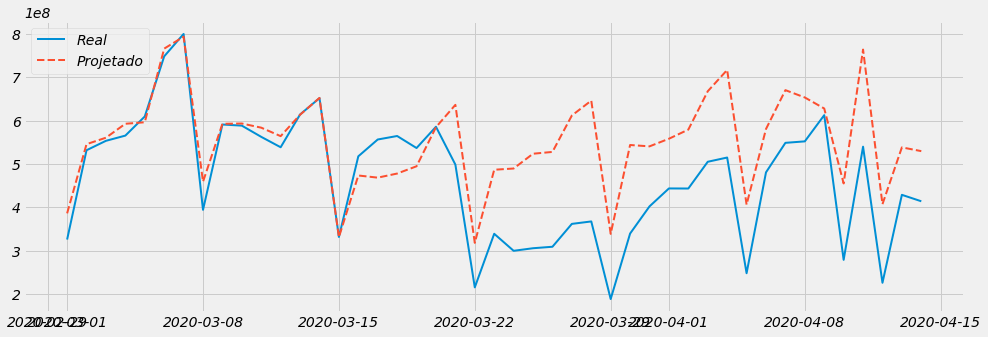

In [16]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

plt.plot(real.index, real[' Debito - Valor '], label = "Real", linewidth=2)
plt.plot(proj['ds'], proj['yhat'], label = "Projetado", linewidth=2, linestyle='dashed')
plt.legend()

In [17]:
pjme_test_fcst.to_csv('future.csv')

In [18]:
pjme_test_fcst['yhat'].to_csv('proj.csv')
real[' Debito - Valor '].to_csv('real.csv')


C:\Users\02.000350\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
C:\Users\02.000350\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


C:\Users\02.000350\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


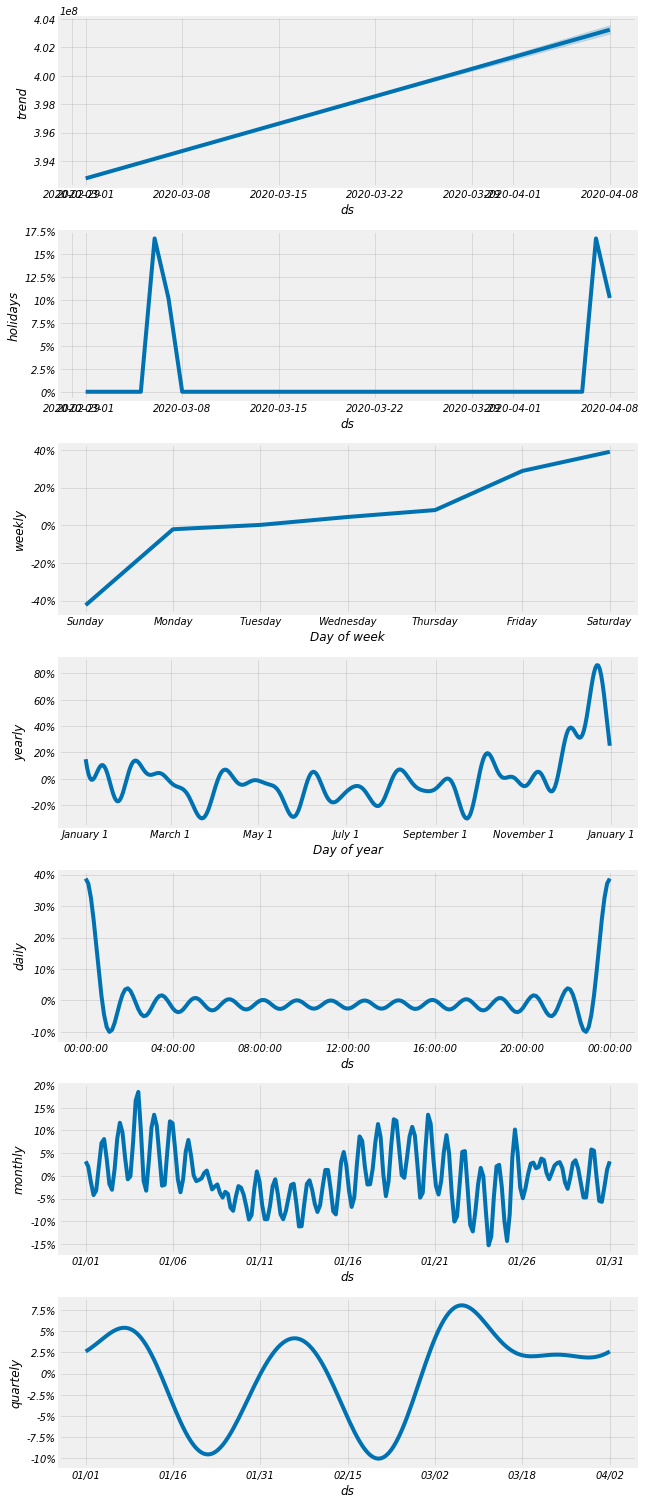

In [18]:
fig = model.plot_components(pjme_test_fcst)

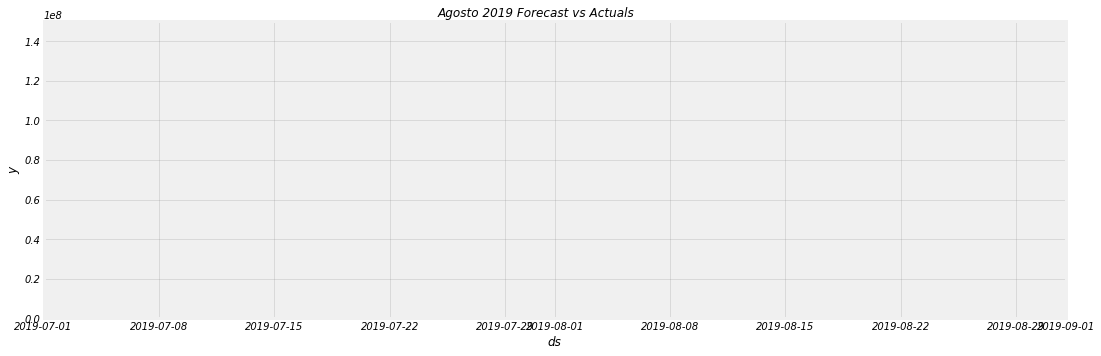

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test[' Debito - Valor '], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='07-01-2019', upper='09-01-2019')
ax.set_ylim(0, 150000000)
plot = plt.suptitle('Agosto 2019 Forecast vs Actuals')

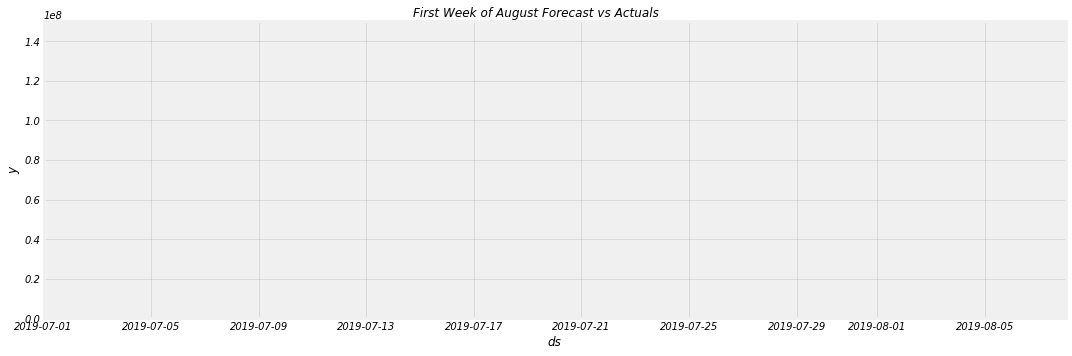

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test[' Débito - Valor '], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='07-01-2019', upper='08-08-2019')
ax.set_ylim(0, 150000000)
plot = plt.suptitle('First Week of August Forecast vs Actuals')

In [20]:
mean_squared_error(y_true=pjme_test[' Débito - Valor '],
                   y_pred=pjme_test_fcst['yhat'])




KeyError: ' Débito - Valor '

In [84]:
mean_absolute_error(y_true=pjme_test[' Débito - Valor '],
                   y_pred=pjme_test_fcst['yhat'])


59409391.727961704

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test[' Debito - Valor '],
                   y_pred=pjme_test_fcst['yhat'])

112.05693958783971

In [21]:
y_pred=pjme_test_fcst['yhat']